# Installs

In [ ]:
!pip install "numpy<2.0"
!pip install torch==2.1.0+cu118 torchvision==0.16.0+cu118 torchaudio==2.1.0 --index-url https://download.pytorch.org/whl/cu118

!pip install torch_geometric


Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 GB 478.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 114.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 97.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 MB 9.2 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 3.2.0
    Uninstalling triton-3.2.0:
      Successfully uninstalled triton-3.2.0
  Attempting uninstall: torch
    Found existing installation: torch 2.6.0+cu124
    Uninstalling torch-2.6.0+cu124:
      Successfully uninstalled torch-2.6.0+cu124
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.21.0+cu124
    Uninstalling torchvision-0.21.0+cu124:
      Successfully uninstalled torchvision-0.21.0+cu124
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.6.0+cu124
    Uninstalling tor

In [ ]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 4.5 MB/s eta 0:00:00


# Imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GraphSAGE, GCNConv, GATConv, GINConv, LayerNorm, BatchNorm
from torch_geometric.nn import global_mean_pool, global_max_pool, global_add_pool, global_sort_pool
from torch_geometric.data import DataLoader
from torch_geometric.nn.aggr import SumAggregation, MeanAggregation, MaxAggregation, StdAggregation

import numpy as np
import pandas as pd
import time
import psutil
import os
import pickle
from typing import Dict, List, Tuple, Any
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import StratifiedKFold
import warnings
from torch_geometric.datasets import TUDataset
from sklearn.model_selection import ParameterSampler

warnings.filterwarnings('ignore')

# Bayesian Optimization imports
try:
    from skopt import gp_minimize
    from skopt.space import Real, Integer, Categorical
    from skopt.utils import use_named_args
    from skopt.acquisition import gaussian_ei
    BAYESIAN_OPT_AVAILABLE = True
except ImportError:
    print("Warning: scikit-optimize not available. Please install with: pip install scikit-optimize")
    BAYESIAN_OPT_AVAILABLE = False

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, global_mean_pool, global_max_pool, global_add_pool
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GINConv, BatchNorm, LayerNorm
from torch_geometric.nn import global_mean_pool, global_max_pool, global_add_pool
from torch_geometric.nn import SAGPooling, TopKPooling, ASAPooling, EdgePooling
from torch_geometric.nn import MemPooling, PANPooling, graclus, max_pool, avg_pool
from torch_geometric.utils import to_dense_batch
from sklearn.model_selection import ParameterSampler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import numpy as np


# Configurations

In [ ]:
torch.manual_seed(42)
np.random.seed(42)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


# Loading the dataset

1. **Nodes**: Amino acids.
2. **Edges**: Connections between amino acids that are within 6 Ångströms of each other.
3. **Labels**: Binary classification indicating whether a protein is an enzyme or not.

Clarification:
1. The 89 features are node features, not graph-level features (Structural information, Chemical properties)


In [ ]:
print("Loading DD dataset...")
dataset = TUDataset(root='/tmp/DD', name='DD')

print(f"Dataset: {dataset}")
print(f"Number of graphs: {len(dataset)}")
print(f"Number of features: {dataset.num_features}")
print(f"Number of classes: {dataset.num_classes}")

# Get first graph for exploration
data = dataset[0]
print(f"\nFirst graph:")
print(f"Number of nodes: {data.x.shape[0]}")
print(f"Number of edges: {data.edge_index.shape[1]}")
print(f"Node feature shape: {data.x.shape}")
print(f"Label: {data.y}")

Loading DD dataset...
Dataset: DD(1178)
Number of graphs: 1178
Number of features: 89
Number of classes: 2

First graph:
Number of nodes: 327
Number of edges: 1798
Node feature shape: torch.Size([327, 89])
Label: tensor([0])


# DATA PREPROCESSING

In [ ]:
data_list = [data for data in dataset]

## splitting

In [ ]:
from sklearn.model_selection import train_test_split

labels = [data.y.item() for data in data_list]
all_indices = list(range(len(data_list)))

# First split: 60% train, 40% (val+test)
train_idx, temp_idx = train_test_split(
    all_indices,
    test_size=0.4,
    stratify=labels,
    random_state=42
)

# Second split: 20% val, 20% test from the remaining 40%
# So test_size=0.5 here means 50% of the 40% => 20% of the total
temp_labels = [labels[i] for i in temp_idx]
val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.5,
    stratify=temp_labels,
    random_state=42
)


In [ ]:
print(f"Train set size: {len(train_idx)}")
print(f"Validation set size: {len(val_idx)}")
print(f"Test set size: {len(test_idx)}")


Train set size: 706
Validation set size: 236
Test set size: 236


In [ ]:
train_dataset = [data_list[i] for i in train_idx]
val_dataset = [data_list[i] for i in val_idx]
test_dataset = [data_list[i] for i in test_idx]

# data loaders

In [ ]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\nBatch size: {batch_size}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of test batches: {len(test_loader)}")


Batch size: 32
Number of training batches: 23
Number of validation batches: 8
Number of test batches: 8


# TRAINING UTILITIES

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def get_memory_usage():
    process = psutil.Process(os.getpid())
    memory_mb = process.memory_info().rss / 1024 / 1024
    if torch.cuda.is_available():
        gpu_memory_mb = torch.cuda.memory_allocated() / 1024 / 1024
        return memory_mb, gpu_memory_mb
    return memory_mb, 0

def measure_inference_time(model, loader, device, num_samples=100):
    model.eval()
    times = []
    with torch.no_grad():
        for i, batch in enumerate(loader):
            if i * batch.y.size(0) >= num_samples:
                break
            batch = batch.to(device)
            start_time = time.time()
            _ = model(batch.x, batch.edge_index, batch.batch)
            end_time = time.time()
            batch_time = (end_time - start_time) / batch.y.size(0)
            times.append(batch_time)
    return np.mean(times) * 1000  # Convert to milliseconds


# Model definition: GINModel

In [ ]:
class GINModelWithLocalPooling(nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes, num_layers,
                 dropout=0.3, global_pool='mean', eps=0.0, train_eps=False,
                 batch_norm=True, layer_norm=False, local_pool='none',
                 pool_ratio=0.5, pool_layers=None):
        super().__init__()

        self.num_layers = num_layers
        self.local_pool = local_pool
        self.pool_layers = pool_layers or []  # Which layers to apply local pooling

        self.convs = nn.ModuleList()
        self.local_pools = nn.ModuleList()
        self.batch_norms = nn.ModuleList() if batch_norm else None
        self.layer_norms = nn.ModuleList() if layer_norm else None

        # First layer
        mlp = nn.Sequential(
            nn.Linear(num_features, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.convs.append(GINConv(mlp, eps=eps, train_eps=train_eps))

        # Hidden layers
        for i in range(num_layers - 2):
            mlp = nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim)
            )
            self.convs.append(GINConv(mlp, eps=eps, train_eps=train_eps))

        # Last layer
        if num_layers > 1:
            mlp = nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim)
            )
            self.convs.append(GINConv(mlp, eps=eps, train_eps=train_eps))

        # Local pooling layers
        for i in range(num_layers):
            if i in self.pool_layers:
                if local_pool == 'sag':
                    self.local_pools.append(SAGPooling(hidden_dim, ratio=pool_ratio))
                elif local_pool == 'topk':
                    self.local_pools.append(TopKPooling(hidden_dim, ratio=pool_ratio))
                elif local_pool == 'asa':
                    self.local_pools.append(ASAPooling(hidden_dim, ratio=pool_ratio))
                elif local_pool == 'edge':
                    self.local_pools.append(EdgePooling(hidden_dim))
                elif local_pool == 'mem':
                    self.local_pools.append(MemPooling(hidden_dim, hidden_dim, heads=4, num_clusters=int(pool_ratio * 100)))
                elif local_pool == 'pan':
                    self.local_pools.append(PANPooling(hidden_dim, ratio=pool_ratio))
                else:
                    self.local_pools.append(nn.Identity())
            else:
                self.local_pools.append(nn.Identity())

        # Normalization layers
        if batch_norm:
            for _ in range(num_layers):
                self.batch_norms.append(BatchNorm(hidden_dim))

        if layer_norm:
            for _ in range(num_layers):
                self.layer_norms.append(LayerNorm(hidden_dim))

        self.classifier = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(dropout)

        # Global pooling
        self.global_pool = {
            'mean': global_mean_pool,
            'max': global_max_pool,
            'add': global_add_pool
        }[global_pool]

    def forward(self, x, edge_index, batch):
        current_edge_index = edge_index
        current_batch = batch

        for i, conv in enumerate(self.convs[:-1]):
            x = conv(x, current_edge_index)

            if self.batch_norms:
                x = self.batch_norms[i](x)
            if self.layer_norms:
                x = self.layer_norms[i](x)

            x = F.relu(x)
            x = self.dropout(x)

            # Apply local pooling if specified for this layer
            if i in self.pool_layers and self.local_pool != 'none':
                if self.local_pool in ['sag', 'topk', 'asa', 'pan']:
                    x, current_edge_index, _, current_batch, _, _ = self.local_pools[i](
                        x, current_edge_index, batch=current_batch
                    )
                elif self.local_pool == 'edge':
                    x, current_edge_index, current_batch, _ = self.local_pools[i](
                        x, current_edge_index, current_batch
                    )
                elif self.local_pool == 'mem':
                    x, current_batch = self.local_pools[i](x, current_batch)
                elif self.local_pool == 'graclus':
                    cluster = graclus(current_edge_index, num_nodes=x.size(0))
                    x, current_batch = max_pool(cluster, x, current_batch)
                    current_edge_index = None  # Need to recompute edges after clustering
                elif self.local_pool == 'avg_pool':
                    cluster = graclus(current_edge_index, num_nodes=x.size(0))
                    x, current_batch = avg_pool(cluster, x, current_batch)
                    current_edge_index = None

        # Last layer
        if len(self.convs) > 0:
            if current_edge_index is not None:
                x = self.convs[-1](x, current_edge_index)
            else:
                # Handle case where edge_index was lost due to clustering
                x = self.convs[-1](x, edge_index)

            if self.batch_norms and len(self.batch_norms) > len(self.convs) - 1:
                x = self.batch_norms[-1](x)
            if self.layer_norms and len(self.layer_norms) > len(self.convs) - 1:
                x = self.layer_norms[-1](x)

        # Global pooling
        x = self.global_pool(x, current_batch)
        return self.classifier(x)

# Evalutation of model

In [ ]:
def evaluate(model, loader, device):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            pred = model(batch.x, batch.edge_index, batch.batch).argmax(dim=1)
            correct += (pred == batch.y).sum().item()
            total += batch.y.size(0)
    return correct / total

def evaluate_detailed(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            pred = model(batch.x, batch.edge_index, batch.batch).argmax(dim=1)
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(batch.y.cpu().numpy())

    return {
        'accuracy': accuracy_score(all_labels, all_preds),
        'f1': f1_score(all_labels, all_preds, average='binary'),
        'precision': precision_score(all_labels, all_preds, average='binary'),
        'recall': recall_score(all_labels, all_preds, average='binary'),
        'predictions': all_preds,
        'labels': all_labels
    }


# Training and evalutation function

In [ ]:
def train_evaluate(model, train_loader, val_loader, test_loader, device, epochs=100, plot_training=False):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    best_val_acc = 0
    patience_counter = 0
    start_time = time.time()

    # For plotting and peak memory tracking
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    epoch_times = []
    peak_train_cpu = peak_train_gpu = 0
    peak_inf_cpu = peak_inf_gpu = 0

    for epoch in range(epochs):
        epoch_start = time.time()

        # Train with peak memory tracking
        model.train()
        epoch_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = criterion(out, batch.y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # Track peak memory during training
        cpu_mem, gpu_mem = get_memory_usage()
        peak_train_cpu = max(peak_train_cpu, cpu_mem)
        peak_train_gpu = max(peak_train_gpu, gpu_mem)

        epoch_time = time.time() - epoch_start
        epoch_times.append(epoch_time)

        # Validate every 10 epochs
        if epoch % 10 == 0:
            val_acc = evaluate(model, val_loader, device)
            train_acc = evaluate(model, train_loader, device)
            val_loss = evaluate_loss(model, val_loader, device, criterion)

            train_losses.append(epoch_loss / len(train_loader))
            val_losses.append(val_loss)
            train_accs.append(train_acc)
            val_accs.append(val_acc)

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= 5:  # Early stopping
                break

    training_time = time.time() - start_time

    # Plot training curves for best model
    if plot_training:
        plt.figure(figsize=(15, 5))
        epochs_range = range(0, len(train_losses) * 10, 10)

        plt.subplot(1, 3, 1)
        plt.plot(epochs_range, train_losses, 'b-', label='Train Loss')
        plt.plot(epochs_range, val_losses, 'r-', label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Train vs Validation Loss')
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.plot(epochs_range, train_accs, 'b-', label='Train Accuracy')
        plt.plot(epochs_range, val_accs, 'r-', label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Train vs Validation Accuracy')
        plt.legend()

        plt.subplot(1, 3, 3)
        plt.plot(epochs_range, train_losses, 'b-', label='Train Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        plt.legend()

        plt.tight_layout()
        plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
        plt.show()

    # Peak memory during inference
    torch.cuda.empty_cache() if torch.cuda.is_available() else None
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            _ = model(batch.x, batch.edge_index, batch.batch)
            cpu_mem, gpu_mem = get_memory_usage()
            peak_inf_cpu = max(peak_inf_cpu, cpu_mem)
            peak_inf_gpu = max(peak_inf_gpu, gpu_mem)

    metrics = evaluate_detailed(model, test_loader, device)
    inference_time = measure_inference_time(model, test_loader, device)

    metrics.update({
        'training_time': training_time,
        'avg_epoch_time': np.mean(epoch_times),
        'parameters': count_parameters(model),
        'peak_train_cpu_mb': peak_train_cpu,
        'peak_train_gpu_mb': peak_train_gpu,
        'peak_inf_cpu_mb': peak_inf_cpu,
        'peak_inf_gpu_mb': peak_inf_gpu,
        'inference_time_ms': inference_time
    })

    return metrics

# Helper function for validation loss


In [ ]:
def evaluate_loss(model, loader, device, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = criterion(out, batch.y)
            total_loss += loss.item()
    return total_loss / len(loader)

# Optimize the model

In [ ]:
def run_gin_tuning(dataset, train_loader, val_loader, test_loader, device, n_trials=30):
    # Hyperparameter distributions for random search
    param_dist = {
        'hidden_dim': [64, 128, 256],
        'num_layers': [2, 3, 4, 5],
        'dropout': [0.1, 0.2, 0.3, 0.5],
        'global_pool': ['mean', 'max', 'add'],
        'eps': [0.0, 0.1, 0.2],
        'train_eps': [True, False],
        'batch_norm': [True, False],
        'layer_norm': [True, False],
    }

    results = []
    best_f1 = 0
    best_model = None

    print(f"GIN Random Search ({n_trials} trials)")
    print("=" * 50)

    # Random search
    for i, params in enumerate(ParameterSampler(param_dist, n_iter=n_trials, random_state=42)):
        print(f"Trial {i+1}/{n_trials}: {params}")

        model = GINModel(
            num_features=dataset.num_features,
            num_classes=dataset.num_classes,
            **params
        ).to(device)

        metrics = train_evaluate(model, train_loader, val_loader, test_loader, device)

        result = {**params, **metrics}
        results.append(result)

        print(f"  F1: {metrics['f1']:.4f}, Acc: {metrics['accuracy']:.4f}, "
              f"Params: {metrics['parameters']}, Time: {metrics['training_time']:.1f}s")

        if metrics['f1'] > best_f1:
            best_f1 = metrics['f1']
            best_model = model

    # Results analysis
    df = pd.DataFrame(results)

    # Save results
    df.to_csv('gin_results.csv', index=False)
    torch.save(best_model.state_dict(), 'best_gin_model.pth')

    # Print comprehensive comparison
    best_result = df.loc[df['f1'].idxmax()]
    print("\n" + "=" * 70)
    print("GIN COMPREHENSIVE RESULTS COMPARISON")
    print("=" * 70)

    # Top 5 models
    top5 = df.nlargest(5, 'f1')[['hidden_dim', 'num_layers', 'dropout', 'eps', 'batch_norm',
                                  'accuracy', 'f1', 'precision', 'recall', 'parameters',
                                  'training_time', 'inference_time_ms']]
    print("\nTOP 5 CONFIGURATIONS:")
    print(top5.round(4).to_string(index=False))

    # Regularization comparison
    print("\nPERFORMANCE BY BATCH NORMALIZATION:")
    bn_comp = df.groupby('batch_norm').agg({
        'accuracy': 'mean', 'f1': 'mean', 'parameters': 'mean',
        'training_time': 'mean', 'inference_time_ms': 'mean'
    }).round(4)
    print(bn_comp)

    # Eps comparison
    print("\nPERFORMANCE BY EPS VALUE:")
    eps_comp = df.groupby('eps').agg({
        'accuracy': 'mean', 'f1': 'mean', 'parameters': 'mean',
        'training_time': 'mean', 'inference_time_ms': 'mean'
    }).round(4)
    print(eps_comp)

    # Best model details
    print(f"\nBEST GIN MODEL DETAILS:")
    print(f"Configuration: {dict(best_result[['hidden_dim', 'num_layers', 'dropout', 'eps', 'batch_norm', 'global_pool']])}")
    print(f"Accuracy: {best_result['accuracy']:.4f}")
    print(f"F1-Score: {best_result['f1']:.4f}")
    print(f"Precision: {best_result['precision']:.4f}")
    print(f"Recall: {best_result['recall']:.4f}")
    print(f"Parameters: {best_result['parameters']:,}")
    print(f"Training Time: {best_result['training_time']:.2f}s")
    print(f"Inference Time: {best_result['inference_time_ms']:.2f}ms")
    print(f"Memory (CPU/GPU): {best_result['memory_cpu_mb']:.1f}/{best_result['memory_gpu_mb']:.1f} MB")

    # Plotting with GIN-specific metrics
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))

    # Performance by eps
    eps_stats = df.groupby('eps')[['accuracy', 'f1']].mean()
    eps_stats.plot(kind='bar', ax=axes[0,0], title='Performance by Eps Value')

    # Batch normalization effect
    df.groupby('batch_norm')[['accuracy', 'f1']].mean().plot(kind='bar', ax=axes[0,1],
                                                              title='Batch Norm Effect')

    # Training time by hidden dimension
    df.groupby('hidden_dim')['training_time'].mean().plot(kind='line', ax=axes[0,2],
                                                          title='Training Time vs Hidden Dim', marker='o', color='red')

    # Inference time by layers
    df.groupby('num_layers')['inference_time_ms'].mean().plot(kind='bar', ax=axes[0,3],
                                                              title='Inference Time by Layers', color='green')

    # F1 vs Parameters (colored by eps)
    scatter = axes[1,0].scatter(df['parameters'], df['f1'], c=df['eps'], cmap='viridis')
    axes[1,0].set_xlabel('Parameters')
    axes[1,0].set_ylabel('F1 Score')
    axes[1,0].set_title('F1 vs Model Size (colored by eps)')
    plt.colorbar(scatter, ax=axes[1,0])



    # Trainable eps effect
    df.groupby('train_eps')['f1'].mean().plot(kind='bar', ax=axes[1,2],
                                              title='Trainable Eps Effect', color='orange')

    # Regularization heatmap (eps vs dropout)
    pivot_data = df.pivot_table(values='f1', index='eps', columns='dropout', aggfunc='mean')
    im = axes[1,3].imshow(pivot_data.values, cmap='viridis', aspect='auto')
    axes[1,3].set_xticks(range(len(pivot_data.columns)))
    axes[1,3].set_xticklabels([f'{x:.1f}' for x in pivot_data.columns])
    axes[1,3].set_yticks(range(len(pivot_data.index)))
    axes[1,3].set_yticklabels([f'{x:.1f}' for x in pivot_data.index])
    axes[1,3].set_title('F1 Heatmap (Eps vs Dropout)')
    plt.colorbar(im, ax=axes[1,3])

    plt.tight_layout()
    plt.savefig('gin_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Save detailed results
    with open('gin_detailed_results.pkl', 'wb') as f:
        pickle.dump({'results': df, 'best_model_params': best_result}, f)

    print(f"\nSaved: gin_results.csv, best_gin_model.pth, gin_analysis.png")

    return df, best_model

In [ ]:
def run_local_pooling_comparison(dataset, train_loader, val_loader, test_loader, device, n_trials=20):
    """
    Comprehensive comparison of different local pooling strategies for GIN
    """

    # Define all local pooling strategies to test
    local_pooling_strategies = {
        'none': {'local_pool': 'none', 'pool_layers': []},
        'sag_early': {'local_pool': 'sag', 'pool_layers': [0], 'pool_ratio': 0.8},
        'sag_mid': {'local_pool': 'sag', 'pool_layers': [1], 'pool_ratio': 0.7},
        'sag_late': {'local_pool': 'sag', 'pool_layers': [2], 'pool_ratio': 0.6},
        'sag_multi': {'local_pool': 'sag', 'pool_layers': [0, 2], 'pool_ratio': 0.7},
        'topk_early': {'local_pool': 'topk', 'pool_layers': [0], 'pool_ratio': 0.8},
        'topk_mid': {'local_pool': 'topk', 'pool_layers': [1], 'pool_ratio': 0.7},
        'topk_late': {'local_pool': 'topk', 'pool_layers': [2], 'pool_ratio': 0.6},
        'topk_multi': {'local_pool': 'topk', 'pool_layers': [0, 2], 'pool_ratio': 0.7},
        'asa_early': {'local_pool': 'asa', 'pool_layers': [0], 'pool_ratio': 0.8},
        'asa_mid': {'local_pool': 'asa', 'pool_layers': [1], 'pool_ratio': 0.7},
        'mem_early': {'local_pool': 'mem', 'pool_layers': [0], 'pool_ratio': 0.5},
        'pan_early': {'local_pool': 'pan', 'pool_layers': [0], 'pool_ratio': 0.8},
        'graclus_early': {'local_pool': 'graclus', 'pool_layers': [0]},
        'avg_pool_early': {'local_pool': 'avg_pool', 'pool_layers': [0]},
    }

    # Base hyperparameters (you can modify these)
    base_params = {
        'hidden_dim': 128,
        'num_layers': 3,
        'dropout': 0.3,
        'global_pool': 'mean',
        'eps': 0.0,
        'train_eps': False,
        'batch_norm': True,
        'layer_norm': False,
    }

    results = []
    strategy_results = {}

    print(f"LOCAL POOLING COMPARISON ({len(local_pooling_strategies)} strategies)")
    print("=" * 80)

    for strategy_name, pool_params in local_pooling_strategies.items():
        print(f"\nTesting Strategy: {strategy_name}")
        print(f"Parameters: {pool_params}")

        try:
            # Combine base params with pooling strategy
            full_params = {**base_params, **pool_params}

            model = GINModelWithLocalPooling(
                num_features=dataset.num_features,
                num_classes=dataset.num_classes,
                **full_params
            ).to(device)

            # Train and evaluate (you'll need to implement this function)
            metrics = train_evaluate(model, train_loader, val_loader, test_loader, device)

            result = {
                'strategy': strategy_name,
                **pool_params,
                **metrics
            }
            results.append(result)
            strategy_results[strategy_name] = metrics

            print(f"  F1: {metrics['f1']:.4f}, Acc: {metrics['accuracy']:.4f}, "
                  f"Params: {metrics['parameters']}, Time: {metrics['training_time']:.1f}s")

        except Exception as e:
            print(f"  ERROR: {str(e)}")
            continue

    # Convert to DataFrame for analysis
    df = pd.DataFrame(results)

    if len(df) == 0:
        print("No successful experiments!")
        return None, None

    # Save results
    df.to_csv('local_pooling_results.csv', index=False)

    # Comprehensive Analysis
    print("\n" + "=" * 80)
    print("LOCAL POOLING COMPREHENSIVE ANALYSIS")
    print("=" * 80)

    # Top performing strategies
    top_strategies = df.nlargest(5, 'f1')[['strategy', 'local_pool', 'pool_layers',
                                          'accuracy', 'f1', 'precision', 'recall',
                                          'parameters', 'training_time', 'inference_time_ms']]
    print("\nTOP 5 LOCAL POOLING STRATEGIES:")
    print(top_strategies.round(4).to_string(index=False))

    # Performance by pooling type
    if 'local_pool' in df.columns:
        print("\nPERFORMANCE BY POOLING TYPE:")
        pool_type_comp = df.groupby('local_pool').agg({
            'accuracy': ['mean', 'std'],
            'f1': ['mean', 'std'],
            'parameters': 'mean',
            'training_time': 'mean',
            'inference_time_ms': 'mean'
        }).round(4)
        print(pool_type_comp)

    # Performance by pooling position
    df['pool_position'] = df['pool_layers'].astype(str)
    print("\nPERFORMANCE BY POOLING POSITION:")
    position_comp = df.groupby('pool_position').agg({
        'accuracy': ['mean', 'std'],
        'f1': ['mean', 'std'],
        'training_time': 'mean'
    }).round(4)
    print(position_comp)

    # Best strategy details
    best_idx = df['f1'].idxmax()
    best_result = df.loc[best_idx]
    print(f"\nBEST LOCAL POOLING STRATEGY:")
    print(f"Strategy: {best_result['strategy']}")
    print(f"Pooling Type: {best_result.get('local_pool', 'N/A')}")
    print(f"Pool Layers: {best_result.get('pool_layers', 'N/A')}")
    print(f"Pool Ratio: {best_result.get('pool_ratio', 'N/A')}")
    print(f"Accuracy: {best_result['accuracy']:.4f}")
    print(f"F1-Score: {best_result['f1']:.4f}")
    print(f"Precision: {best_result['precision']:.4f}")
    print(f"Recall: {best_result['recall']:.4f}")
    print(f"Parameters: {best_result['parameters']:,}")
    print(f"Training Time: {best_result['training_time']:.2f}s")
    print(f"Inference Time: {best_result['inference_time_ms']:.2f}ms")

    # Create comprehensive visualizations
    create_pooling_visualizations(df)

    # Save detailed results
    with open('local_pooling_detailed_results.pkl', 'wb') as f:
        pickle.dump({
            'results': df,
            'strategy_results': strategy_results,
            'best_strategy': best_result.to_dict()
        }, f)

    print(f"\nSaved: local_pooling_results.csv, local_pooling_analysis.png, local_pooling_detailed_results.pkl")

    return df, strategy_results

In [ ]:

def create_pooling_visualizations(df):
    """Create comprehensive visualizations for local pooling comparison"""

    plt.style.use('default')
    fig = plt.figure(figsize=(24, 16))

    # Create a 4x4 grid
    gs = fig.add_gridspec(4, 4, hspace=0.3, wspace=0.3)

    # 1. F1 Score by Strategy (horizontal bar chart)
    ax1 = fig.add_subplot(gs[0, :2])
    strategy_f1 = df.set_index('strategy')['f1'].sort_values(ascending=True)
    colors = plt.cm.viridis(np.linspace(0, 1, len(strategy_f1)))
    bars = ax1.barh(range(len(strategy_f1)), strategy_f1.values, color=colors)
    ax1.set_yticks(range(len(strategy_f1)))
    ax1.set_yticklabels(strategy_f1.index, fontsize=8)
    ax1.set_xlabel('F1 Score')
    ax1.set_title('F1 Score by Local Pooling Strategy', fontweight='bold')
    ax1.grid(axis='x', alpha=0.3)

    # Add value labels on bars
    for i, (bar, val) in enumerate(zip(bars, strategy_f1.values)):
        ax1.text(val + 0.001, i, f'{val:.3f}', va='center', fontsize=7)

    # 2. Accuracy vs F1 scatter plot
    ax2 = fig.add_subplot(gs[0, 2:])
    scatter = ax2.scatter(df['accuracy'], df['f1'],
                         c=df.index, cmap='tab20', s=100, alpha=0.7)
    ax2.set_xlabel('Accuracy')
    ax2.set_ylabel('F1 Score')
    ax2.set_title('Accuracy vs F1 Score', fontweight='bold')
    ax2.grid(alpha=0.3)

    # Add strategy labels to points
    for i, row in df.iterrows():
        ax2.annotate(row['strategy'][:8], (row['accuracy'], row['f1']),
                    xytext=(5, 5), textcoords='offset points', fontsize=6)

    # 3. Performance by Pooling Type (if available)
    if 'local_pool' in df.columns and df['local_pool'].nunique() > 1:
        ax3 = fig.add_subplot(gs[1, :2])
        pooling_performance = df.groupby('local_pool')[['accuracy', 'f1']].mean()
        x = np.arange(len(pooling_performance))
        width = 0.35

        bars1 = ax3.bar(x - width/2, pooling_performance['accuracy'], width,
                       label='Accuracy', alpha=0.8, color='skyblue')
        bars2 = ax3.bar(x + width/2, pooling_performance['f1'], width,
                       label='F1 Score', alpha=0.8, color='lightcoral')

        ax3.set_xlabel('Pooling Type')
        ax3.set_ylabel('Score')
        ax3.set_title('Performance by Pooling Type', fontweight='bold')
        ax3.set_xticks(x)
        ax3.set_xticklabels(pooling_performance.index, rotation=45)
        ax3.legend()
        ax3.grid(axis='y', alpha=0.3)

        # Add value labels
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                ax3.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                        f'{height:.3f}', ha='center', va='bottom', fontsize=8)

    # 4. Training Time vs Performance
    ax4 = fig.add_subplot(gs[1, 2:])
    bubble_sizes = (df['parameters'] - df['parameters'].min()) / (df['parameters'].max() - df['parameters'].min()) * 300 + 50
    scatter2 = ax4.scatter(df['training_time'], df['f1'],
                          s=bubble_sizes, alpha=0.6, c=df['accuracy'], cmap='RdYlBu_r')
    ax4.set_xlabel('Training Time (seconds)')
    ax4.set_ylabel('F1 Score')
    ax4.set_title('Training Time vs F1 Score\n(Bubble size: Parameters, Color: Accuracy)', fontweight='bold')
    ax4.grid(alpha=0.3)

    # Add colorbar
    cbar = plt.colorbar(scatter2, ax=ax4)
    cbar.set_label('Accuracy')

    # 5. Parameters vs Performance
    ax5 = fig.add_subplot(gs[2, :2])
    ax5.scatter(df['parameters'], df['f1'], alpha=0.7, s=80, color='green')
    ax5.set_xlabel('Number of Parameters')
    ax5.set_ylabel('F1 Score')
    ax5.set_title('Model Size vs Performance', fontweight='bold')
    ax5.grid(alpha=0.3)

    # Add trend line
    z = np.polyfit(df['parameters'], df['f1'], 1)
    p = np.poly1d(z)
    ax5.plot(df['parameters'], p(df['parameters']), "r--", alpha=0.8, linewidth=2)

    # 6. Inference Time Comparison
    ax6 = fig.add_subplot(gs[2, 2:])
    df_sorted = df.sort_values('inference_time_ms')
    bars = ax6.bar(range(len(df_sorted)), df_sorted['inference_time_ms'],
                   color='orange', alpha=0.7)
    ax6.set_xlabel('Strategy (sorted by speed)')
    ax6.set_ylabel('Inference Time (ms)')
    ax6.set_title('Inference Time by Strategy', fontweight='bold')
    ax6.set_xticks(range(len(df_sorted)))
    ax6.set_xticklabels(df_sorted['strategy'], rotation=45, ha='right', fontsize=8)
    ax6.grid(axis='y', alpha=0.3)

    # 7. Performance Distribution
    ax7 = fig.add_subplot(gs[3, :2])
    metrics = ['accuracy', 'f1', 'precision', 'recall']
    bp = ax7.boxplot([df[metric] for metric in metrics], labels=metrics, patch_artist=True)
    colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    ax7.set_title('Performance Metrics Distribution', fontweight='bold')
    ax7.set_ylabel('Score')
    ax7.grid(axis='y', alpha=0.3)

    # 8. Efficiency Score (F1 / Training Time)
    ax8 = fig.add_subplot(gs[3, 2:])
    df['efficiency'] = df['f1'] / df['training_time']
    efficiency_sorted = df.sort_values('efficiency', ascending=True)
    bars = ax8.barh(range(len(efficiency_sorted)), efficiency_sorted['efficiency'],
                    color='purple', alpha=0.7)
    ax8.set_yticks(range(len(efficiency_sorted)))
    ax8.set_yticklabels(efficiency_sorted['strategy'], fontsize=8)
    ax8.set_xlabel('Efficiency (F1 Score / Training Time)')
    ax8.set_title('Strategy Efficiency Ranking', fontweight='bold')
    ax8.grid(axis='x', alpha=0.3)

    plt.suptitle('Comprehensive Local Pooling Analysis for GIN Models',
                 fontsize=16, fontweight='bold', y=0.98)

    plt.tight_layout()
    plt.savefig('local_pooling_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Create additional heatmap for detailed comparison
    create_pooling_heatmap(df)

In [ ]:

def create_pooling_heatmap(df):
    """Create a detailed heatmap comparing all strategies across all metrics"""

    # Select key metrics for heatmap
    metrics = ['accuracy', 'f1', 'precision', 'recall', 'training_time', 'inference_time_ms']

    # Normalize metrics for better visualization (0-1 scale)
    df_norm = df.copy()
    for metric in metrics:
        if metric in ['training_time', 'inference_time_ms']:
            # For time metrics, lower is better, so invert
            df_norm[metric] = 1 - (df[metric] - df[metric].min()) / (df[metric].max() - df[metric].min())
        else:
            # For performance metrics, higher is better
            df_norm[metric] = (df[metric] - df[metric].min()) / (df[metric].max() - df[metric].min())

    # Create heatmap
    plt.figure(figsize=(12, 8))
    heatmap_data = df_norm.set_index('strategy')[metrics]

    sns.heatmap(heatmap_data, annot=True, cmap='RdYlGn', center=0.5,
                square=True, linewidths=0.5, cbar_kws={"shrink": .8},
                fmt='.3f')

    plt.title('Local Pooling Strategies Performance Heatmap\n(Normalized: Green=Better, Red=Worse)',
              fontweight='bold', pad=20)
    plt.xlabel('Metrics')
    plt.ylabel('Pooling Strategies')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig('pooling_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()


In [ ]:
def run_complete_pooling_analysis(dataset, train_loader, val_loader, test_loader, device):
    """
    Run the complete local pooling analysis
    """
    print("Starting Comprehensive Local Pooling Analysis...")
    print("This will test multiple pooling strategies and generate detailed comparisons.")

    # Run the comparison
    results_df, strategy_results = run_local_pooling_comparison(
        dataset, train_loader, val_loader, test_loader, device, n_trials=20
    )

    if results_df is not None:
        print("\nAnalysis Complete!")
        print("Generated files:")
        print("- local_pooling_results.csv")
        print("- local_pooling_analysis.png")
        print("- pooling_heatmap.png")
        print("- local_pooling_detailed_results.pkl")

        return results_df, strategy_results
    else:
        print("Analysis failed - no successful experiments")
        return None, None

Starting Comprehensive Local Pooling Analysis...
This will test multiple pooling strategies and generate detailed comparisons.
LOCAL POOLING COMPARISON (15 strategies)

Testing Strategy: none
Parameters: {'local_pool': 'none', 'pool_layers': []}
  F1: 0.6077, Acc: 0.6992, Params: 95106, Time: 27.5s

Testing Strategy: sag_early
Parameters: {'local_pool': 'sag', 'pool_layers': [0], 'pool_ratio': 0.8}
  F1: 0.6467, Acc: 0.7500, Params: 95364, Time: 23.4s

Testing Strategy: sag_mid
Parameters: {'local_pool': 'sag', 'pool_layers': [1], 'pool_ratio': 0.7}
  F1: 0.5882, Acc: 0.7331, Params: 95364, Time: 20.9s

Testing Strategy: sag_late
Parameters: {'local_pool': 'sag', 'pool_layers': [2], 'pool_ratio': 0.6}
  F1: 0.6491, Acc: 0.6610, Params: 95364, Time: 15.6s

Testing Strategy: sag_multi
Parameters: {'local_pool': 'sag', 'pool_layers': [0, 2], 'pool_ratio': 0.7}
  F1: 0.6635, Acc: 0.7034, Params: 95622, Time: 26.7s

Testing Strategy: topk_early
Parameters: {'local_pool': 'topk', 'pool_layer

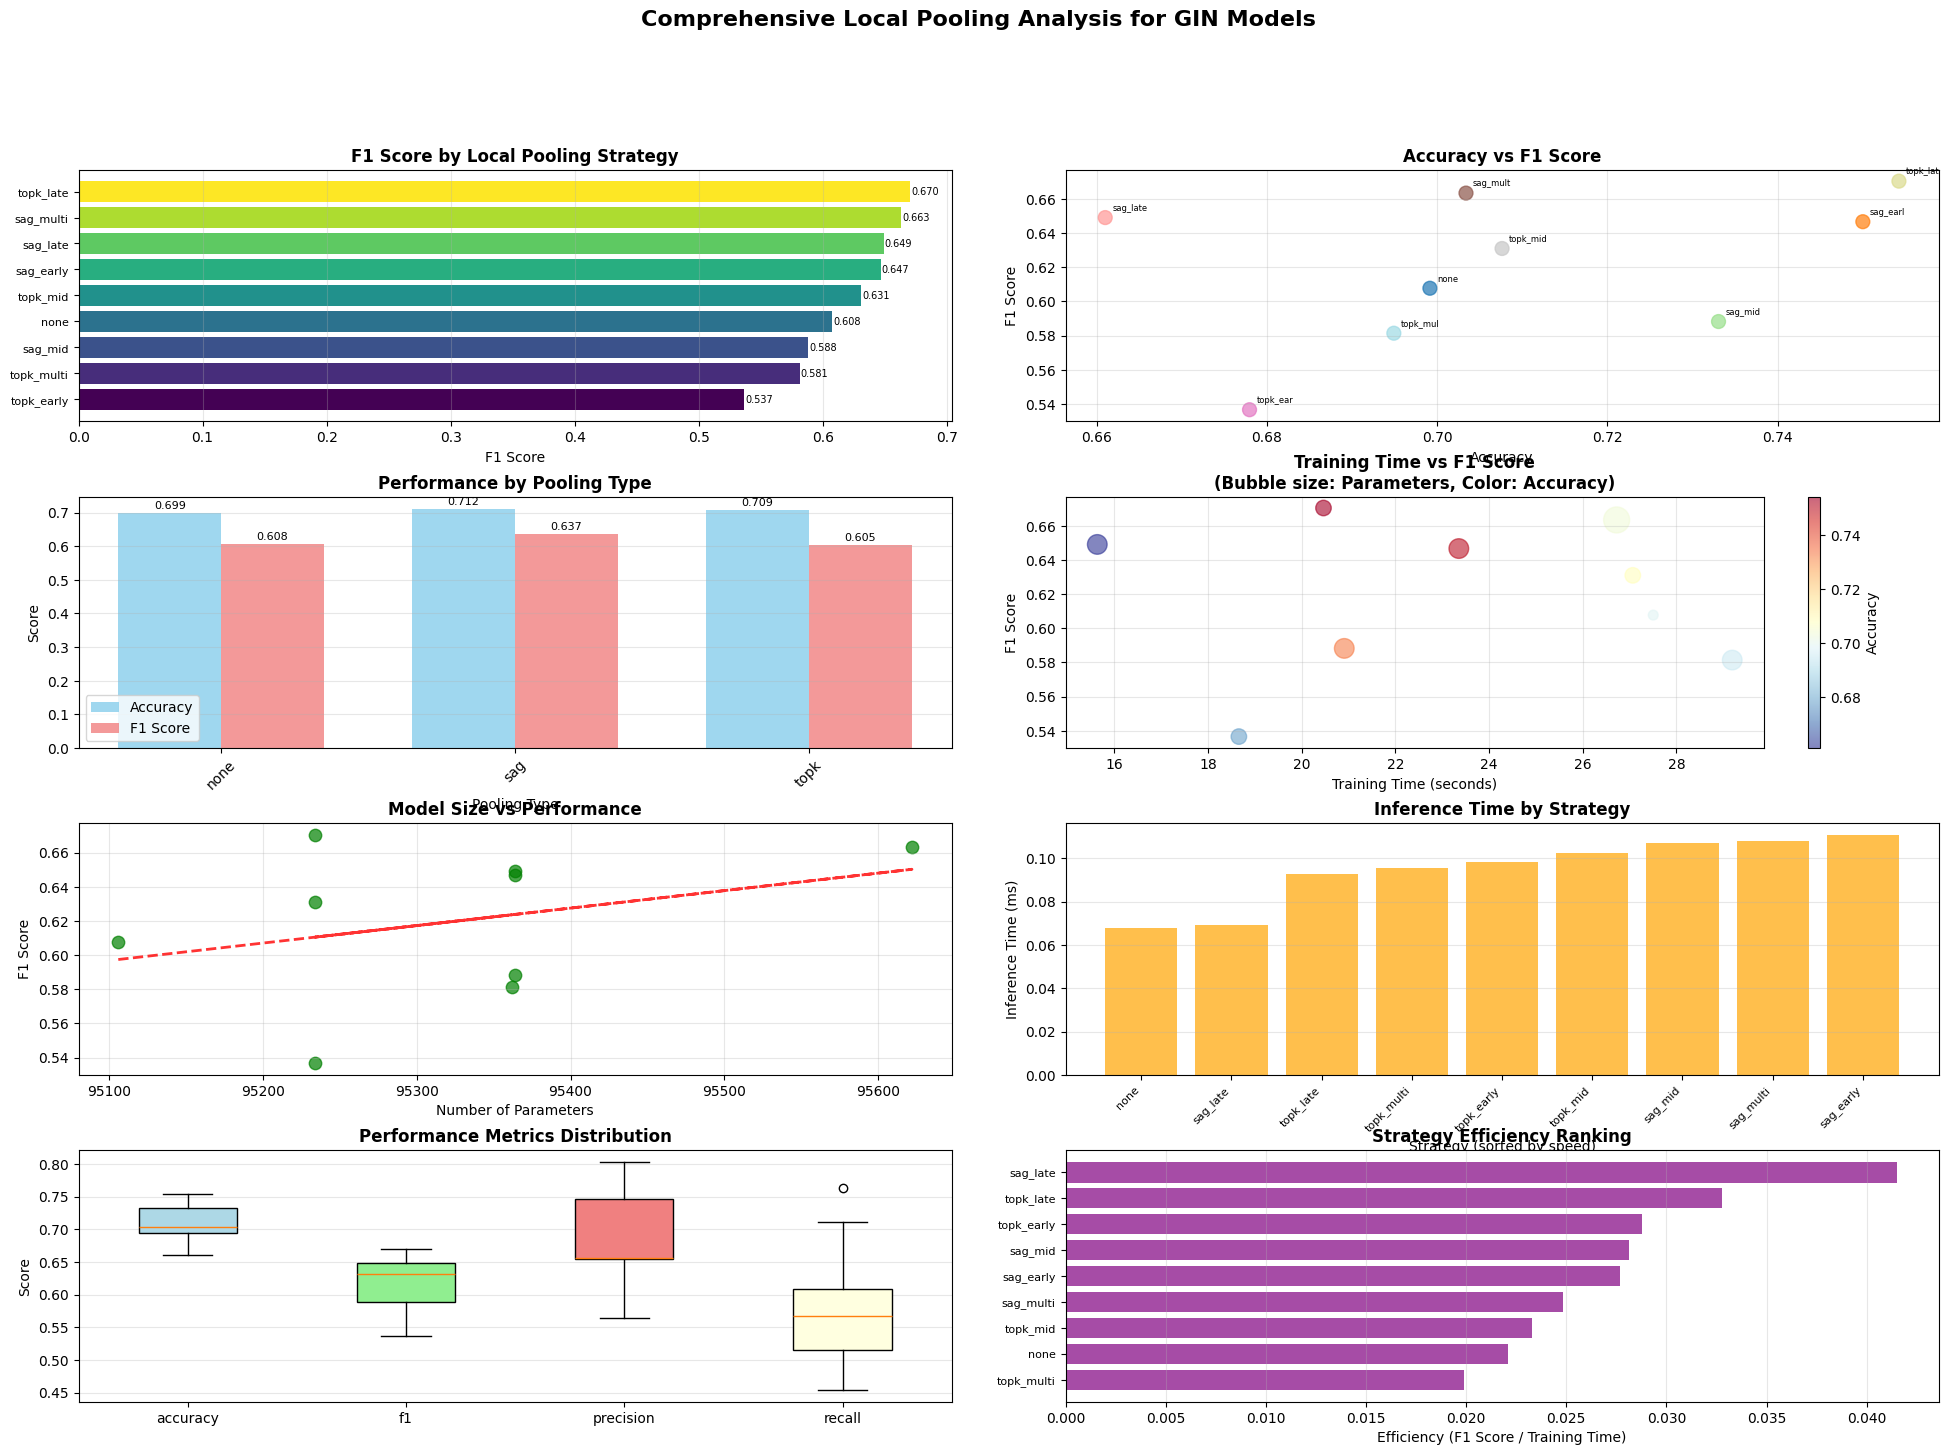

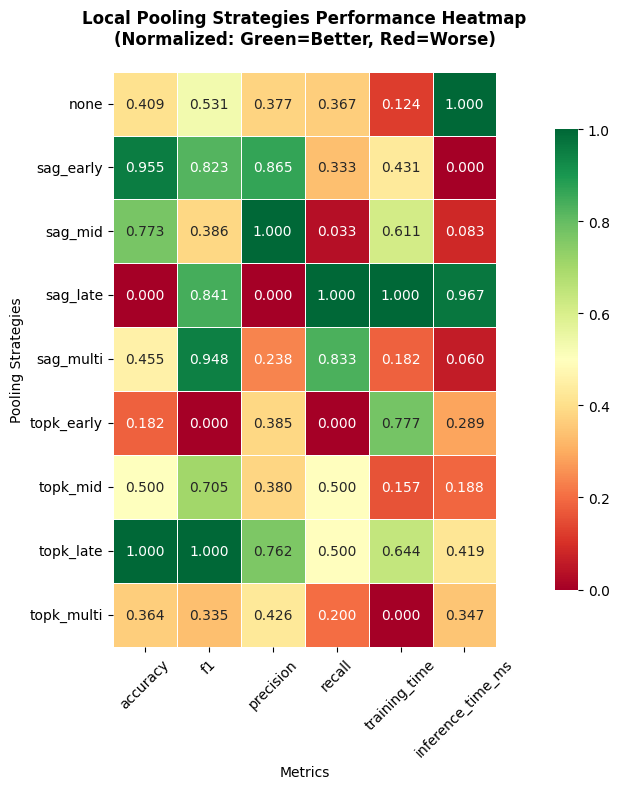


Saved: local_pooling_results.csv, local_pooling_analysis.png, local_pooling_detailed_results.pkl

Analysis Complete!
Generated files:
- local_pooling_results.csv
- local_pooling_analysis.png
- pooling_heatmap.png
- local_pooling_detailed_results.pkl


In [ ]:
results_df, strategy_results = run_complete_pooling_analysis(
    dataset, train_loader, val_loader, test_loader, device
)